vertics = 10
ver_num = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

random graph 1
edges = [(0, 1), (0, 6), (0, 7), (0, 9), (1, 2), (1, 7), (1, 8), (1, 9), (2, 3), (2, 5), (2, 7), (3, 6), (3, 7), (4, 7), (5, 6), (6, 7), (6, 9), (7, 8)]

random graph 2
edges = [(0, 2), (0, 4), (0, 6), (0, 9), (1, 2), (1, 3), (1, 5), (1, 8), (1, 9), (2, 4), (2, 5), (2, 6), (2, 8), (3, 4), (3, 7), (3, 8), (4, 6), (4, 7), (5, 9), (6, 7), (6, 8), (7, 8), (7, 9)]

random graph 3
edges = [(0, 2), (0, 3), (0, 4), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (2, 6), (2, 9), (3, 4), (3, 7), (3, 8), (4, 5), (4, 8), (5, 7), (5, 9), (6, 7), (7, 8), (7, 9)]

random graph 4
edges = [(0, 1), (0, 2), (0, 5), (0, 7), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 8), (4, 7), (4, 9), (5, 6), (5, 7), (5, 9), (6, 7), (6, 8), (6, 9), (7, 9)]

random graph 5
edges = [(0, 2), (0, 3), (0, 5), (0, 9), (1, 2), (1, 3), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 6), (2, 8), (3, 4), (3, 5), (3, 7), (3, 9), (5, 8

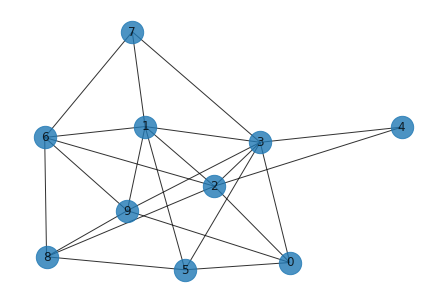

In [1]:
import warnings
warnings.simplefilter(action='ignore',)

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

from time import time
import networkx as nx

n = 10
iter = 5
print("vertics = " + str(n))
print("ver_num = " + str([i for i in range(n)]))

value_dc_qaoa_ls = []
ubound_sdp_ls = []
for i in range(iter):
    print("\nrandom graph " + str(i+1))

    G = nx.erdos_renyi_graph(n, 0.1, 100 * i, directed=False)
    while nx.is_connected(G) == False:
        G = nx.erdos_renyi_graph(n, 0.5, directed=False)
    print("edges = " + str(list(G.edges)))
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [2]:
def create_circ(G, theta):
    
    nqubits = 10 ########################################
    qc = QuantumCircuit(nqubits)
    
    r = 5
    pv = ParameterVector('p',2*nqubits*r)
    
    t = 0
    for i in range(r):   
        for j in range(nqubits // 2):
            qc.ry(theta[t+2*j], j)
            qc.rz(theta[t+2*j+1], j)

        if i < r-1: 
            for j in range(nqubits // 2-1):
                qc.cnot(j, (j+1))
            qc.cnot(nqubits//2-1, 0)
        t += nqubits

    t = int(len(theta)/2)
    for i in range(r):   
        for j in range(nqubits // 2):
            qc.ry(theta[t+2*j], j+nqubits//2)
            qc.rz(theta[t+2*j+1], j+nqubits//2)
        if i < r-1: 
            for j in range(nqubits//2, nqubits-1):
                qc.cnot(j, j+1)
            qc.cnot(nqubits-1, nqubits//2)
        t += 10
    
    qc.measure_all()
    return qc

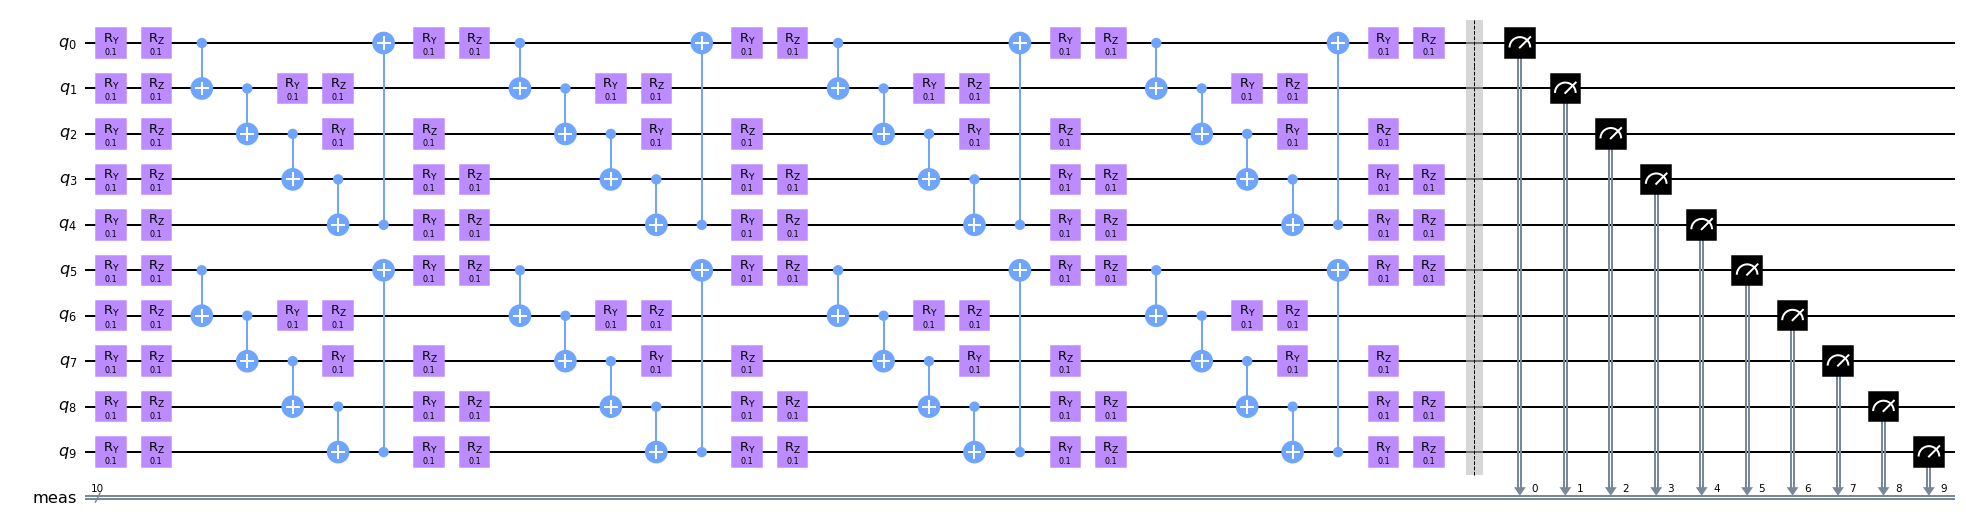

In [3]:
para = []
repeat = 5
for i in range(repeat*2*n): para.append(0.1)

qc_test = create_circ(G, para)

qc_test.draw(output="mpl", fold=-1)

In [4]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(G, p, shots=1024):
     
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=1024).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [5]:
from scipy.optimize import minimize
start = time()
expectation = get_expectation(G, p=50)
res = minimize(expectation, 
              para, 
              method='COBYLA')
end = time()
print("Cost time:",end-start)
print(res)

Cost time: 13.789424180984497
     fun: -14.173828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 994
  status: 1
 success: True
       x: array([ 0.54402039,  0.68683006,  0.31006713,  0.09843713,  1.55962775,
        0.74326219,  1.3391845 ,  0.08108611,  0.27332514, -0.73492181,
        1.71526607,  0.17344169,  0.96181893, -0.07090335,  0.52609054,
        0.38227835,  1.85148118,  0.07969137, -0.40475687,  0.2257584 ,
        1.18706602,  0.2133325 ,  1.79585291,  1.20898499,  1.29108206,
        0.16555508, -0.05538041, -0.18724173,  1.47254535,  0.36367283,
        1.17728514,  0.7984384 ,  1.41210493,  1.62839857,  0.40844935,
       -0.41765424, -0.04584735,  1.08485699, -0.2293355 ,  1.09782633,
       -0.17827207,  0.11344497,  0.02901344,  0.08652994, -0.0265873 ,
       -0.20627868,  0.74661924,  0.25767911,  0.4706267 , -0.08481043,
        1.36371655, -0.37105698,  0.60120786,  0.30455131,  1.20246926,
        0.06217852,  1.17633347,  0.125

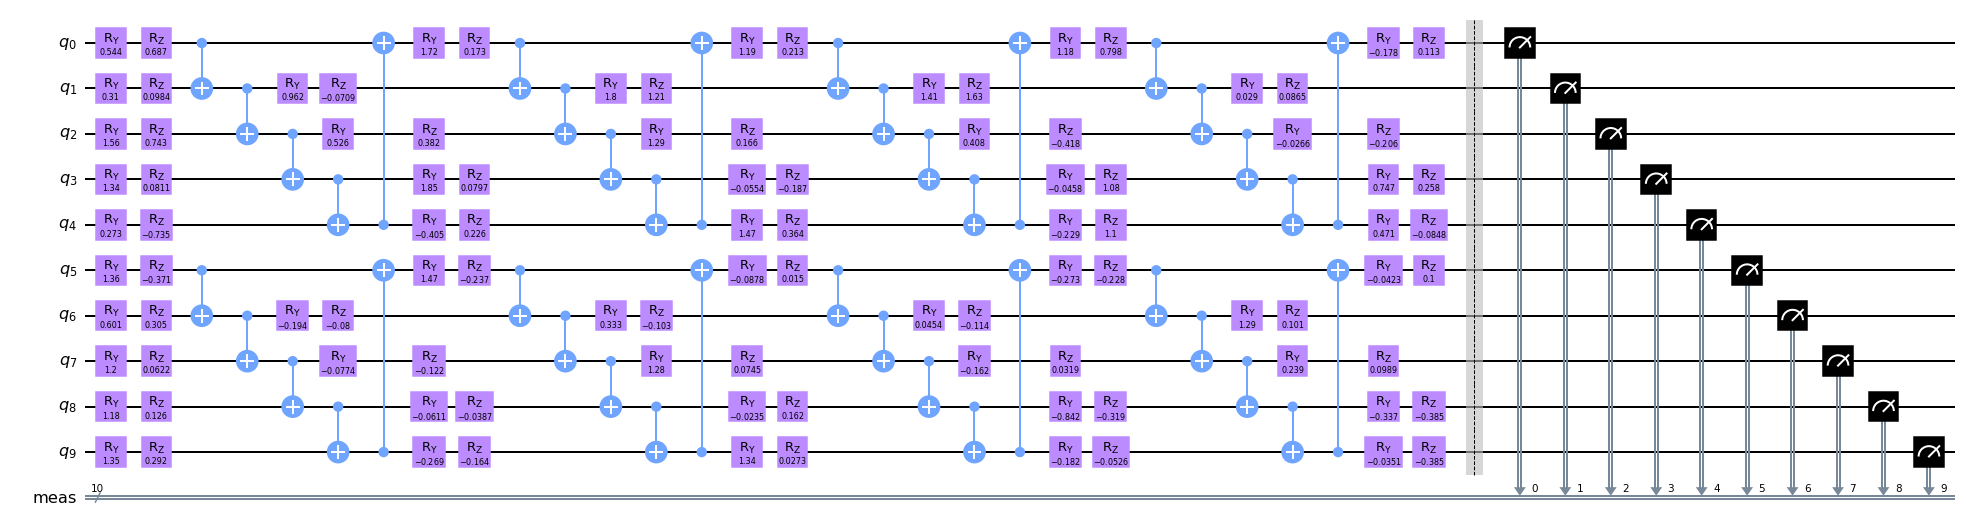

In [6]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc_res = create_circ(G, res.x)
qc_res.draw(output="mpl",fold=-1)

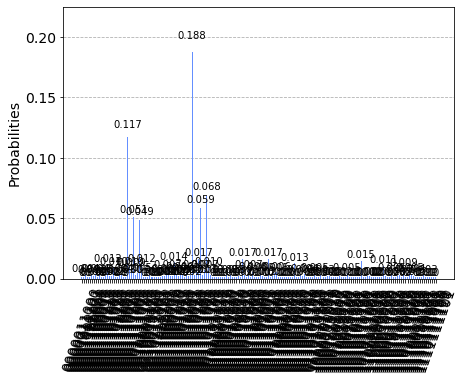

In [7]:
result = backend.run(qc_res, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

In [8]:
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Best 4 solutions:")
es = 0
for i in sort:
    print(i)
    es+=1
    if es == 4: break

Best 4 solutions:
0011010101
0001110101
0011011101
0011011010


In [9]:
import cvxpy as cvx
import networkx as nx

def sdp_solver(G):

    n = len(G)
    adj_mat = nx.adjacency_matrix(G).toarray()
    Y = cvx.Variable((n, n), PSD=True)
    cut_size = 0.25 * cvx.sum(cvx.multiply(adj_mat, 1 - Y))
    problem = cvx.Problem(cvx.Maximize(cut_size), [cvx.diag(Y) == 1])
    opt_val = problem.solve(cvx.SCS)

    return opt_val

ubound_sdp = sdp_solver(G)
ubound_sdp_ls.append(ubound_sdp)
print("SDP upper bound: " + str(ubound_sdp))

SDP upper bound: 18.369029772904266


In [10]:
ans = "0011010101"
cut_dc_qaoa1 = ["solid" if ans[u] == ans[v] else "dashed" for (u, v) in list(G.edges)]
value_dc_qaoa = cut_dc_qaoa1.count("dashed")
value_dc_qaoa_ls.append(value_dc_qaoa)
print("binary string: " + str(ans) + ", max cut = " + str(float(value_dc_qaoa))) 

binary string: 0011010101, max cut = 17.0


#### Parameterized $U_1$

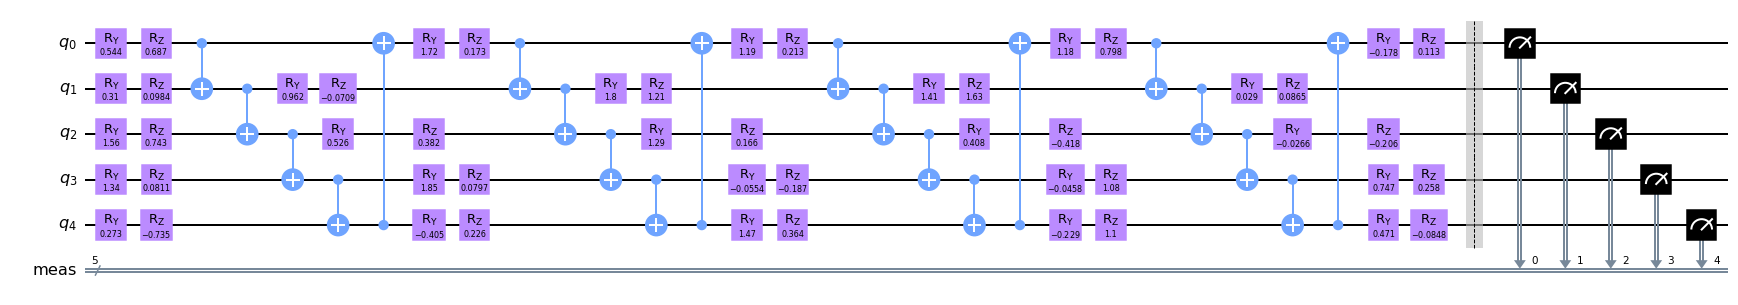

In [11]:
repeat = 5

qc_u1 = QuantumCircuit(int(n/2))
pv_u1 = ParameterVector('p_1', n*repeat)

t = 0
for i in range(repeat):
    for j in range(n // 2):
        qc_u1.ry(res.x[t+2*j], j)
        qc_u1.rz(res.x[t+2*j+1], j)
        
    if i < repeat-1: 
        for j in range(n // 2-1):
            qc_u1.cnot(j, (j+1))
        qc_u1.cnot(n//2-1, 0)
    t += n

qc_u1.measure_all()
qc_u1.draw(output="mpl", fold=-1)

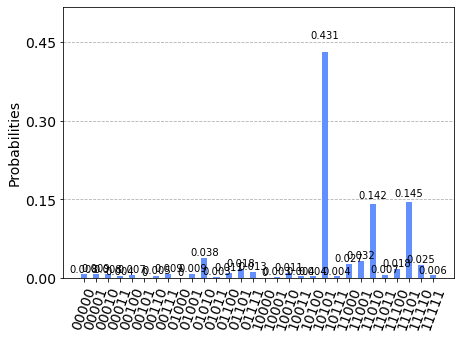

In [12]:
result = backend.run(qc_u1, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

#### Parameterized $U_2$

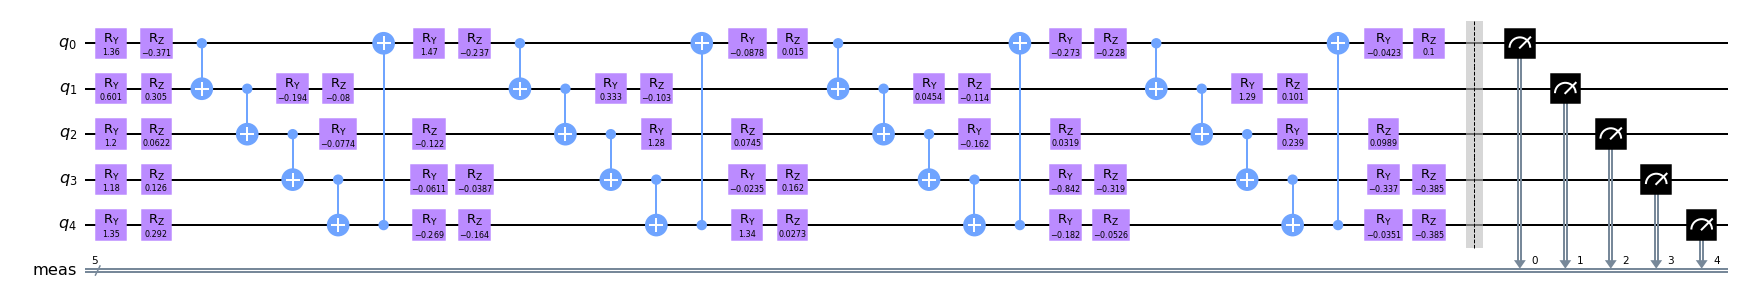

In [13]:
repeat = 5

qc_u2 = QuantumCircuit(int(n/2))
pv_u2 = ParameterVector('p_2', n*repeat)

    
t = int(len(res.x)/2)
for i in range(repeat):   
    for j in range(n // 2):
        qc_u2.ry(res.x[t+2*j], j)
        qc_u2.rz(res.x[t+2*j+1], j)
        
    if i < repeat-1: 
        for j in range(n // 2-1):
            qc_u2.cnot(j, (j+1))
        qc_u2.cnot(n//2-1, 0)
    t += n
   
qc_u2.measure_all()
qc_u2.draw(output="mpl",fold=-1)

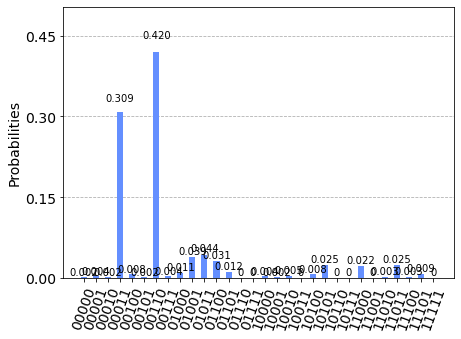

In [14]:
result = backend.run(qc_u2, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)